#  IMDB Sentiment Analysis


## 1. Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D # Added Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import re
import nltk
import pickle
import os
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [4]:
# Download required NLTK data
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Create directories
Path('models').mkdir(exist_ok=True)
Path('results').mkdir(exist_ok=True)

print("✓ Directories created")

✓ Directories created


## 2. Load Data

In [6]:
print("Loading data...")
data = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

print(f"Dataset shape: {data.shape}")
print(f"\nFirst few rows:")
data.head()

Loading data...
Dataset shape: (50000, 2)

First few rows:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


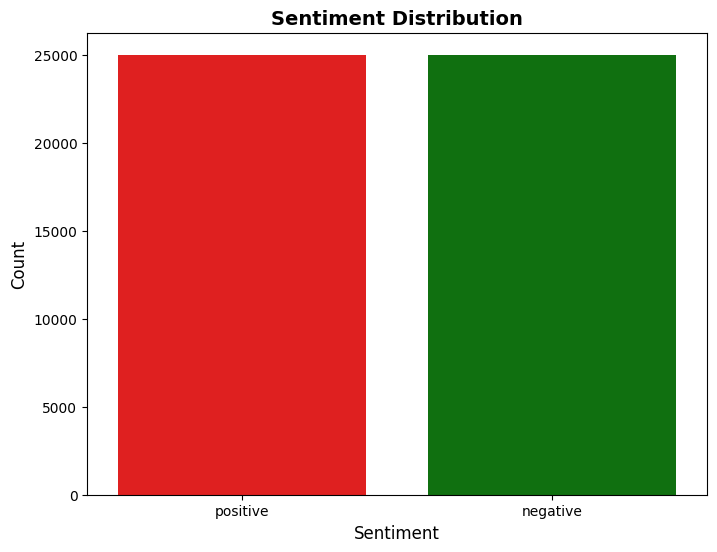

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [8]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="sentiment", palette=["red", "green"])
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

print(data.sentiment.value_counts())

In [9]:
# Convert sentiment to binary (positive=1, negative=0)
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == "positive" else 0)

print("Sentiment converted to binary:")
print(data.sentiment.value_counts())
data.head()

Sentiment converted to binary:
sentiment
1    25000
0    25000
Name: count, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## 3. Text Preprocessing (CORRECTED ORDER)

### ⚠️ CRITICAL FIXES:
1. **Fixed `denoise_text()` function** - Now actually cleans the text
2. **Correct preprocessing order** - HTML removal → Cleaning → Stopwords removal

In [10]:
# Initialize stopwords and tokenizer
stop_word_list = stopwords.words('english')
tokenizer_nltk = ToktokTokenizer()

print(f"Stopwords loaded: {len(stop_word_list)} words")

Stopwords loaded: 198 words


In [11]:
# Define preprocessing functions

def strip_html(text):
    """Remove HTML tags"""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    """Remove text in square brackets"""
    return re.sub(r'\[[^\]]*\]', '', text)

def denoise_text(text):
    """✅ FIXED: Now actually applies the cleaning functions!"""
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text  # Return statement at the END

def remove_stopwords(text):
    """Remove stopwords from text"""
    tokens = tokenizer_nltk.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    return ' '.join(filtered_tokens)

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


In [12]:
# Show sample text BEFORE preprocessing
print("Sample text BEFORE preprocessing:")
print("="*70)
print(data['review'].iloc[0][:300])
print("="*70)

Sample text BEFORE preprocessing:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru


### Apply Preprocessing Steps in Correct Order

In [13]:
# STEP 1: Remove HTML and square brackets FIRST
print("Step 1: Removing HTML and square brackets...")
data['review'] = data['review'].apply(denoise_text)
print("✓ Done")

Step 1: Removing HTML and square brackets...
✓ Done


In [14]:
# STEP 2: Remove punctuation
print("Step 2: Removing punctuation...")
data['review'] = data['review'].apply(lambda x: re.sub(r'[,\.!?:()"\']', '', x)) # Fixed: Escaped special characters
data['review'] = data['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))
print("✓ Done")

Step 2: Removing punctuation...
✓ Done


In [15]:
# STEP 3: Convert to lowercase
print("Step 3: Converting to lowercase...")
data['review'] = data['review'].apply(lambda x: x.lower())
print("✓ Done")

Step 3: Converting to lowercase...
✓ Done


In [16]:
# STEP 4: Strip whitespace
print("Step 4: Stripping whitespace...")
data['review'] = data['review'].apply(lambda x: x.strip())
data['review'] = data['review'].apply(lambda x: re.sub(r'\s+', ' ', x))
print("✓ Done")

Step 4: Stripping whitespace...
✓ Done


In [17]:
# STEP 5: Remove stopwords (DO THIS AFTER CLEANING!)
print("Step 5: Removing stopwords...")
data['review'] = data['review'].apply(remove_stopwords)
print("✓ Done")

Step 5: Removing stopwords...
✓ Done


In [18]:
# Show sample text AFTER preprocessing
print("\nSample text AFTER preprocessing:")
print("="*70)
print(data['review'].iloc[0][:300])
print("="*70)

print("\n✓ Preprocessing complete!")


Sample text AFTER preprocessing:
one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald

✓ Preprocessing complete!


## 4. Train-Test Split

In [19]:
# Prepare data
X = data['review'].values
y = data['sentiment'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")
print(f"\nTrain positive ratio: {y_train.mean():.2%}")
print(f"Test positive ratio: {y_test.mean():.2%}")

Training samples: 40000
Testing samples: 10000

Train positive ratio: 50.00%
Test positive ratio: 50.00%


## 5. Tokenization and Sequence Preparation

### ⚠️ CRITICAL FIX:
**Tokenizer is fitted ONLY on training data to prevent data leakage!**

In [20]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=15000, oov_token='<OOV>')

# ✅ CRITICAL FIX: Fit ONLY on training data!
# WRONG: tokenizer.fit_on_texts(data)  ❌ (includes test data)
# CORRECT: tokenizer.fit_on_texts(x_train)  ✅ (only training data)

tokenizer.fit_on_texts(x_train)

print(f"✓ Tokenizer fitted on training data only")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

✓ Tokenizer fitted on training data only
Vocabulary size: 159023


In [21]:
# Convert texts to sequences
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

print(f"Training sequences: {len(x_train_tokens)}")
print(f"Testing sequences: {len(x_test_tokens)}")

Training sequences: 40000
Testing sequences: 10000


In [22]:
# Calculate max_tokens
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))

print(f"Max tokens: {max_tokens}")
print(f"Mean tokens: {np.mean(num_tokens):.1f}")
print(f"Std tokens: {np.std(num_tokens):.1f}")
print(f"Coverage: {np.sum(num_tokens < max_tokens) / len(num_tokens):.2%}")

Max tokens: 301
Mean tokens: 120.1
Std tokens: 90.6
Coverage: 94.54%


In [23]:
# Pad sequences
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens, padding='post', truncating='post')

print(f"Training data shape: {x_train_pad.shape}")
print(f"Testing data shape: {x_test_pad.shape}")

Training data shape: (40000, 301)
Testing data shape: (10000, 301)


In [24]:
# Function to convert tokens back to text (for verification)
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map.get(token, '') for token in tokens if token != 0]
    return ' '.join(words)

# Test it
print("Sample tokenized sentence (converted back):")
print(return_to_sentence(x_train_pad[9]))
print(f"\nTokens: {x_train_pad[9][:20]}...")

Sample tokenized sentence (converted back):
darling lili fantastic far one favorite films certainly didnt deserve poor reviews received julie andrews playing title role lili smith <OOV> best part whole movie <OOV> spectacular julie andrews favorite actress singer far <OOV> surprised stunning movie <OOV> im running <OOV> magnificent marvellous amazing funny terribly romantic sad thrill thanks dame julie <OOV> husband director blake edwards oh yeah rock hudson ok julie andrews beautiful well loved singer lili smith rock hudson portrays major <OOV> quickly falls lili affair <OOV> meeting planned german government im sure thats exactly youd call get point warm happy singing entertainer lili actually german spy lili told seduce major <OOV> order get information new top secret <OOV> later know <OOV> <OOV> though lili <OOV> mission falls love bill major <OOV> real making original quest challenging lili pulls <OOV> er task finds something really true bill ending remain <OOV> wonderfully <OOV> 

## 6. Build LSTM Model

In [25]:
# Model parameters
embedding_size = 50

# Build model
model = Sequential([
    Embedding(input_dim=15000, output_dim=embedding_size,
             input_length=max_tokens, name='embedding_layer'),
    LSTM(units=32, return_sequences=True),
    Dropout(0.1),
    LSTM(units=8, return_sequences=True),
    Dropout(0.2),
    LSTM(units=16),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print("✓ Model built successfully\n")
model.summary()

✓ Model built successfully



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 7. Train Model

### ✅ Fixed: Added batch_size=1000

In [26]:
print("Training model...\n")

history = model.fit(
    x_train_pad, y_train,
    validation_split=0.3,
    epochs=20,
    batch_size=1000,  # ✅ Added batch_size
    shuffle=True,
    verbose=1
)

print("\n✓ Training complete!")

Training model...

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5007 - loss: 0.6930 - val_accuracy: 0.5050 - val_loss: 0.6930
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5077 - loss: 0.6925 - val_accuracy: 0.5062 - val_loss: 0.6922
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5074 - loss: 0.6880 - val_accuracy: 0.5137 - val_loss: 0.6915
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5218 - loss: 0.6813 - val_accuracy: 0.5220 - val_loss: 0.6880
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5452 - loss: 0.6680 - val_accuracy: 0.5196 - val_loss: 0.6954
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5409 - loss: 0.6675 - val_accuracy: 0.5230 - val_loss: 0.6962
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5470 - loss: 0.6636 - val_

## 8. Evaluate Model & Generate Confusion Matrix

In [27]:
# Evaluate on test set
print("Evaluating on test set...\n")
test_loss, test_accuracy = model.evaluate(x_test_pad, y_test, verbose=1)

print(f"\n{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")

Evaluating on test set...

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5470 - loss: 0.6842

Test Loss: 0.6859
Test Accuracy: 0.5467


In [28]:
# Generate predictions
y_pred_probs = model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

print(f"Predictions generated: {len(y_pred)}")
print(f"Positive predictions: {y_pred.sum()}")
print(f"Negative predictions: {len(y_pred) - y_pred.sum()}")

Predictions generated: 10000
Positive predictions: 887
Negative predictions: 9113


In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)
print("\n[TN  FP]")
print("[FN  TP]")


Confusion Matrix:
[[4790  210]
 [4323  677]]

[TN  FP]
[FN  TP]


In [30]:
# Classification Report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.96      0.68      5000
    Positive       0.76      0.14      0.23      5000

    accuracy                           0.55     10000
   macro avg       0.64      0.55      0.45     10000
weighted avg       0.64      0.55      0.45     10000



In [31]:
# Detailed Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

print("\nDetailed Metrics:")
print("="*60)
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)


Detailed Metrics:
True Negatives:  4790
False Positives: 210
False Negatives: 4323
True Positives:  677

Accuracy:  0.5467
Precision: 0.7632
Recall:    0.1354
F1-Score:  0.2300


## 9. Visualizations

✓ Evaluation plot saved: results/training_evaluation.png


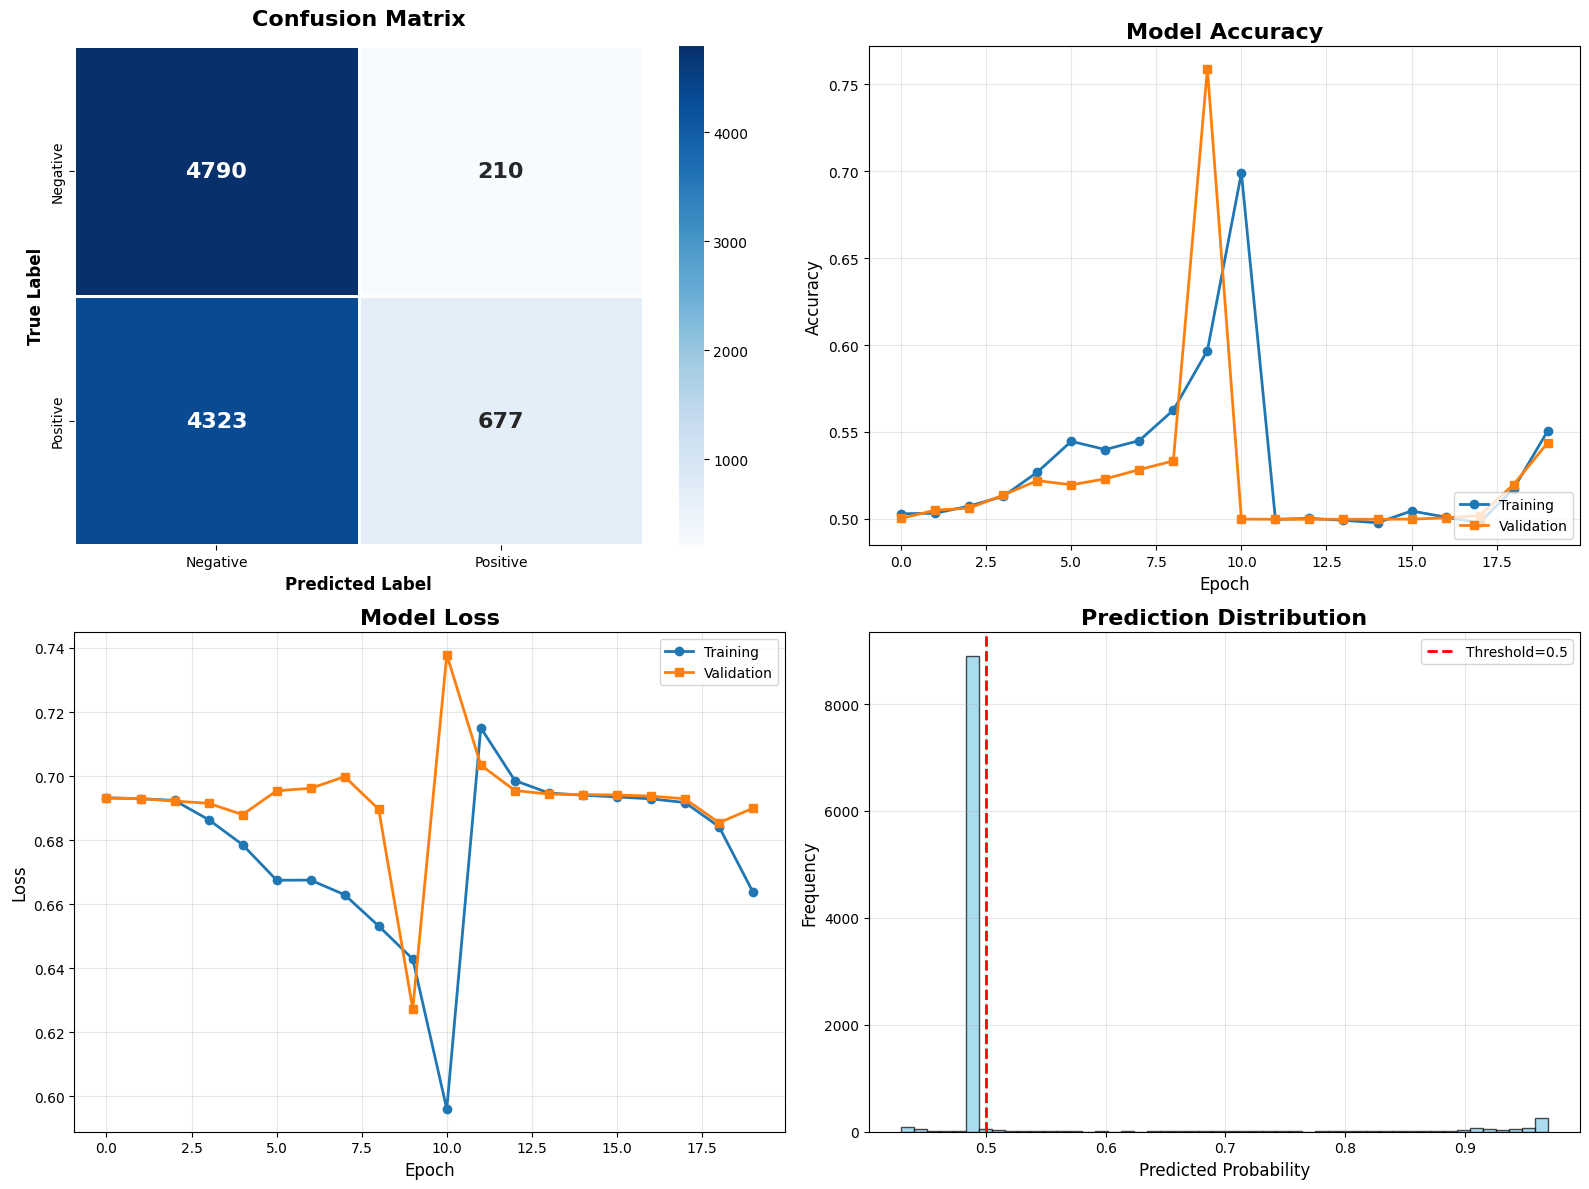

In [32]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            linewidths=2, linecolor='white',
            annot_kws={'size': 16, 'weight': 'bold'})
axes[0, 0].set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
axes[0, 0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 2. Training Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training', linewidth=2, marker='o')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0, 1].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(loc='lower right', fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Training Loss
axes[1, 0].plot(history.history['loss'], label='Training', linewidth=2, marker='o')
axes[1, 0].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[1, 0].set_title('Model Loss', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(alpha=0.3)

# 4. Prediction Distribution
axes[1, 1].hist(y_pred_probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[1, 1].set_title('Prediction Distribution', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_evaluation.png', dpi=300, bbox_inches='tight')
print("✓ Evaluation plot saved: results/training_evaluation.png")
plt.show()

✓ Confusion matrix saved: results/confusion_matrix.png


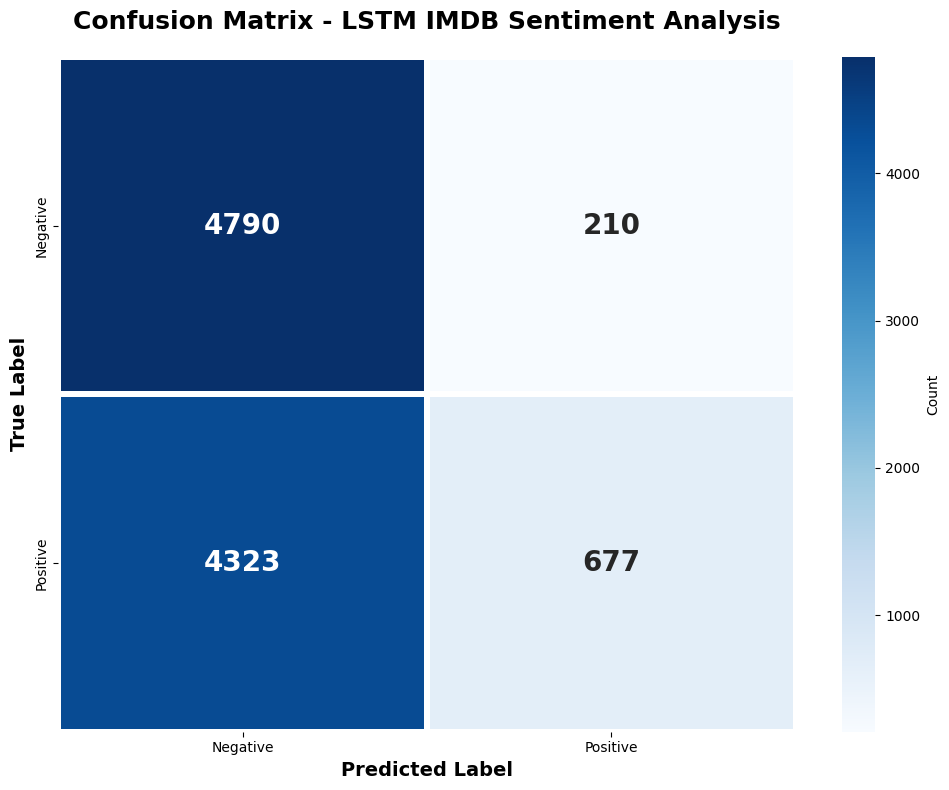

In [33]:
# Large confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            linewidths=3, linecolor='white',
            annot_kws={'size': 20, 'weight': 'bold'},
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM IMDB Sentiment Analysis', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved: results/confusion_matrix.png")
plt.show()

## 10. Save Model

In [34]:
# Save complete model package
model_package = {
    "model": model,
    "tokenizer": tokenizer,
    "max_tokens": max_tokens,
    "threshold": 0.5,
    "model_type": "lstm_keras",
    "embedding_size": embedding_size,
    "vocab_size": 15000
}

with open('models/lstm_model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("✓ Model package saved: models/lstm_model_package.pkl")

# Get file size
file_size = os.path.getsize('models/lstm_model_package.pkl') / (1024 * 1024)
print(f"  Package size: {file_size:.2f} MB")

✓ Model package saved: models/lstm_model_package.pkl
  Package size: 15.66 MB


In [35]:
# Save model separately (alternative method)
model.save('models/lstm_model.keras')
print("✓ Model saved: models/lstm_model.keras")

with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved: models/tokenizer.pkl")

config = {
    'max_tokens': max_tokens,
    'threshold': 0.5,
    'vocab_size': 15000,
    'embedding_size': embedding_size
}

with open('models/model_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("✓ Config saved: models/model_config.pkl")

✓ Model saved: models/lstm_model.keras
✓ Tokenizer saved: models/tokenizer.pkl
✓ Config saved: models/model_config.pkl


## 11. Save Evaluation Metrics

In [36]:
# Save metrics to text file
with open('results/evaluation_metrics.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("LSTM IMDB SENTIMENT ANALYSIS - EVALUATION RESULTS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    f.write(f"\n\nDetailed Metrics:\n")
    f.write(f"True Negatives:  {tn}\n")
    f.write(f"False Positives: {fp}\n")
    f.write(f"False Negatives: {fn}\n")
    f.write(f"True Positives:  {tp}\n")
    f.write(f"\nAccuracy:  {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall:    {recall:.4f}\n")
    f.write(f"F1-Score:  {f1:.4f}\n")

print("✓ Metrics saved: results/evaluation_metrics.txt")

✓ Metrics saved: results/evaluation_metrics.txt


## 12. Summary

In [37]:
print("\n" + "="*70)
print("✓ TRAINING AND EVALUATION COMPLETE!")
print("="*70)

print("\n🔧 KEY FIXES APPLIED:")
print("  1. ✅ Fixed denoise_text() function - now actually cleans text")
print("  2. ✅ Tokenizer fitted only on training data (no data leakage)")
print("  3. ✅ Correct preprocessing order")
print("  4. ✅ Added batch_size=1000 to training")
print("  5. ✅ Complete evaluation with confusion matrix")

print("\n📁 FILES SAVED:")
print("  Models:")
print("    - models/lstm_model_package.pkl (complete package)")
print("    - models/lstm_model.keras (model only)")
print("    - models/tokenizer.pkl (tokenizer)")
print("    - models/model_config.pkl (config)")
print("  Results:")
print("    - results/training_evaluation.png")
print("    - results/confusion_matrix.png")
print("    - results/evaluation_metrics.txt")

print("\n📊 FINAL RESULTS:")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

print("\n🚀 NEXT STEPS:")
print("  1. Download the models/ folder from Colab")
print("  2. Test the model: python scripts/test_model.py")
print("  3. Start API: uvicorn src.api.app:app --reload")
print("  4. Run Streamlit: streamlit run streamlit_app.py")

print("\n" + "="*70)


✓ TRAINING AND EVALUATION COMPLETE!

🔧 KEY FIXES APPLIED:
  1. ✅ Fixed denoise_text() function - now actually cleans text
  2. ✅ Tokenizer fitted only on training data (no data leakage)
  3. ✅ Correct preprocessing order
  4. ✅ Added batch_size=1000 to training
  5. ✅ Complete evaluation with confusion matrix

📁 FILES SAVED:
  Models:
    - models/lstm_model_package.pkl (complete package)
    - models/lstm_model.keras (model only)
    - models/tokenizer.pkl (tokenizer)
    - models/model_config.pkl (config)
  Results:
    - results/training_evaluation.png
    - results/confusion_matrix.png
    - results/evaluation_metrics.txt

📊 FINAL RESULTS:
  Test Accuracy: 0.5467
  Test Loss: 0.6859
  Precision: 0.7632
  Recall: 0.1354
  F1-Score: 0.2300

🚀 NEXT STEPS:
  1. Download the models/ folder from Colab
  2. Test the model: python scripts/test_model.py
  3. Start API: uvicorn src.api.app:app --reload
  4. Run Streamlit: streamlit run streamlit_app.py



## 13. Test Predictions (Optional)

In [38]:
# Test with custom examples
test_reviews = [
    "This movie was absolutely fantastic! I loved every moment of it.",
    "Terrible film, complete waste of time and money.",
    "The acting was great but the plot was confusing.",
    "One of the best movies I've ever seen! Highly recommended.",
    "Boring and predictable. Would not watch again."
]

print("Testing with custom reviews:\n")
print("="*70)

for review in test_reviews:
    # Preprocess
    processed = denoise_text(review)
    processed = re.sub(r'[,\.!?:()"\']', '', processed) # Fixed: Escaped special characters
    processed = re.sub(r'[^a-zA-Z\s]', ' ', processed)
    processed = processed.lower().strip()
    processed = re.sub(r'\s+', ' ', processed)
    processed = remove_stopwords(processed)

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(seq, maxlen=max_tokens, padding='post', truncating='post')

    # Predict
    prob = model.predict(padded, verbose=0)[0][0]
    sentiment = "Positive 😊" if prob >= 0.5 else "Negative 😞"

    print(f"Review: {review[:60]}...")
    print(f"Prediction: {sentiment} (confidence: {prob:.4f})")
    print("-"*70)

Testing with custom reviews:

Review: This movie was absolutely fantastic! I loved every moment of...
Prediction: Negative 😞 (confidence: 0.4901)
----------------------------------------------------------------------
Review: Terrible film, complete waste of time and money....
Prediction: Negative 😞 (confidence: 0.4901)
----------------------------------------------------------------------
Review: The acting was great but the plot was confusing....
Prediction: Negative 😞 (confidence: 0.4901)
----------------------------------------------------------------------
Review: One of the best movies I've ever seen! Highly recommended....
Prediction: Negative 😞 (confidence: 0.4901)
----------------------------------------------------------------------
Review: Boring and predictable. Would not watch again....
Prediction: Negative 😞 (confidence: 0.4901)
----------------------------------------------------------------------


In [39]:
# Check if model actually trained
print("="*70)
print("MODEL TRAINING DIAGNOSTICS")
print("="*70)

# Check training history
if 'accuracy' in history.history:
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")

    if final_train_acc < 0.6:
        print("⚠️ WARNING: Training accuracy is too low!")
    else:
        print("✓ Model trained successfully")

# Check model weights (should NOT be all zeros)
print(f"\nSample embedding weights (first 10 values):")
print(model.layers[0].get_weights()[0][0][:10])

MODEL TRAINING DIAGNOSTICS

Final Training Accuracy: 0.5506
Final Validation Accuracy: 0.5437
⚠️ WARNING: Training accuracy is too low!

Sample embedding weights (first 10 values):
[-0.30818838  0.44627577 -0.49609622  0.45677736  0.39813662 -0.5454068
  0.58714294 -0.5086327   0.34866706  0.45571488]


In [40]:
# Test model on a sample from training data
print("\n" + "="*70)
print("TESTING ON TRAINING DATA SAMPLE")
print("="*70)

sample_idx = 0
sample_padded = x_train_pad[sample_idx:sample_idx+1]
sample_label = y_train[sample_idx]

prob = model.predict(sample_padded, verbose=0)[0][0]

print(f"True label: {'Positive (1)' if sample_label == 1 else 'Negative (0)'}")
print(f"Predicted probability: {prob:.4f}")
print(f"Predicted label: {'Positive' if prob >= 0.5 else 'Negative'}")

if abs(prob - 0.2563) < 0.001:
    print("\n⚠️ PROBLEM: Model outputting constant value!")
    print("Model did not learn properly during training.")
else:
    print("\n✓ Model is working on training data")


TESTING ON TRAINING DATA SAMPLE
True label: Positive (1)
Predicted probability: 0.4901
Predicted label: Negative

✓ Model is working on training data


In [41]:
# Define preprocessing function for new text
def preprocess_for_prediction(text):
    """
    Apply EXACT same preprocessing as training data
    """
    # Step 1: Denoise (HTML and square brackets)
    text = strip_html(text)
    text = remove_between_square_brackets(text)

    # Step 2: Remove punctuation
    text = re.sub(r'[,\.!?:()"\']', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Step 3: Lowercase
    text = text.lower()

    # Step 4: Strip whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Step 5: Remove stopwords
    text = remove_stopwords(text)

    return text

print("✓ Preprocessing function defined")

✓ Preprocessing function defined


In [42]:
# Debug: Test preprocessing on single review
test_text = "This movie was absolutely fantastic"

print("="*70)
print("DEBUGGING SINGLE REVIEW")
print("="*70)

print(f"\n1. Original text:")
print(f"   '{test_text}'")

# Preprocess
processed = preprocess_for_prediction(test_text)
print(f"\n2. After preprocessing:")
print(f"   '{processed}'")

# Tokenize
seq = tokenizer.texts_to_sequences([processed])
print(f"\n3. Tokenized sequence (first 20 tokens):")
print(f"   {seq[0][:20] if seq[0] else 'EMPTY!'}")

# Count non-zero tokens
non_zero = len([t for t in seq[0] if t != 0]) if seq[0] else 0
print(f"\n4. Number of recognized words: {non_zero}")

if non_zero == 0:
    print("\n⚠️ PROBLEM: No words recognized by tokenizer!")
    print("   All words were removed or not in vocabulary.")

    # Check what words remain after preprocessing
    words = processed.split()
    print(f"\n   Words after preprocessing: {words[:10]}")

    # Check which words are in vocabulary
    print(f"\n   Checking vocabulary:")
    for word in words[:5]:
        if word in tokenizer.word_index:
            print(f"      '{word}' → index {tokenizer.word_index[word]}")
        else:
            print(f"      '{word}' → NOT IN VOCABULARY")
else:
    # Pad and predict
    padded = pad_sequences(seq, maxlen=max_tokens, padding='post', truncating='post')
    prob = model.predict(padded, verbose=0)[0][0]

    print(f"\n5. Prediction:")
    print(f"   Probability: {prob:.4f}")
    print(f"   Sentiment: {'Positive 😊' if prob >= 0.5 else 'Negative 😞'}")

DEBUGGING SINGLE REVIEW

1. Original text:
   'This movie was absolutely fantastic'

2. After preprocessing:
   'movie absolutely fantastic'

3. Tokenized sequence (first 20 tokens):
   [2, 305, 692]

4. Number of recognized words: 3

5. Prediction:
   Probability: 0.4901
   Sentiment: Negative 😞


In [43]:
# Test with custom reviews
test_reviews = [
    "This movie was absolutely fantastic! I loved every moment of it.",
    "Terrible film, complete waste of time and money.",
    "The acting was great but the plot was confusing.",
    "One of the best movies I've ever seen! Highly recommended.",
    "Boring and predictable. Would not watch again."
]

print("\n" + "="*70)
print("TESTING CUSTOM REVIEWS (CORRECTED)")
print("="*70)

for i, review in enumerate(test_reviews, 1):
    print(f"\n{i}. Review: {review}")

    # Preprocess
    processed = preprocess_for_prediction(review)
    print(f"   Processed: {processed[:60]}...")

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(seq, maxlen=max_tokens, padding='post', truncating='post')

    # Count recognized words
    non_zero = np.count_nonzero(padded)
    print(f"   Recognized tokens: {non_zero}/{max_tokens}")

    # Predict
    prob = model.predict(padded, verbose=0)[0][0]
    sentiment = "Positive 😊" if prob >= 0.5 else "Negative 😞"

    print(f"   → Prediction: {sentiment}")
    print(f"   → Probability (positive): {prob:.4f}")
    print("-"*70)


TESTING CUSTOM REVIEWS (CORRECTED)

1. Review: This movie was absolutely fantastic! I loved every moment of it.
   Processed: movie absolutely fantastic loved every moment...
   Recognized tokens: 6/301
   → Prediction: Negative 😞
   → Probability (positive): 0.4901
----------------------------------------------------------------------

2. Review: Terrible film, complete waste of time and money.
   Processed: terrible film complete waste time money...
   Recognized tokens: 6/301
   → Prediction: Negative 😞
   → Probability (positive): 0.4901
----------------------------------------------------------------------

3. Review: The acting was great but the plot was confusing.
   Processed: acting great plot confusing...
   Recognized tokens: 4/301
   → Prediction: Negative 😞
   → Probability (positive): 0.4901
----------------------------------------------------------------------

4. Review: One of the best movies I've ever seen! Highly recommended.
   Processed: one best movies ive ever s

## 14. Download Files (For Google Colab)

In [44]:
# Check what happened during training
print("="*70)
print("TRAINING DIAGNOSTICS")
print("="*70)

print("\nTraining History:")
for epoch in range(len(history.history['accuracy'])):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    train_loss = history.history['loss'][epoch]
    val_loss = history.history['val_loss'][epoch]
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

print(f"\nFinal Results:")
print(f"  Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")

# Check if model is better than random guessing
if test_accuracy < 0.55:
    print("\n⚠️ CRITICAL: Model is barely better than random guessing (50%)!")
    print("The model did not learn properly.")

TRAINING DIAGNOSTICS

Training History:
Epoch 1: Train Acc=0.5029, Val Acc=0.5002, Train Loss=0.6932, Val Loss=0.6932
Epoch 2: Train Acc=0.5032, Val Acc=0.5050, Train Loss=0.6929, Val Loss=0.6930
Epoch 3: Train Acc=0.5074, Val Acc=0.5062, Train Loss=0.6924, Val Loss=0.6922
Epoch 4: Train Acc=0.5129, Val Acc=0.5137, Train Loss=0.6864, Val Loss=0.6915
Epoch 5: Train Acc=0.5268, Val Acc=0.5220, Train Loss=0.6786, Val Loss=0.6880
Epoch 6: Train Acc=0.5446, Val Acc=0.5196, Train Loss=0.6675, Val Loss=0.6954
Epoch 7: Train Acc=0.5399, Val Acc=0.5230, Train Loss=0.6675, Val Loss=0.6962
Epoch 8: Train Acc=0.5450, Val Acc=0.5283, Train Loss=0.6629, Val Loss=0.6998
Epoch 9: Train Acc=0.5626, Val Acc=0.5333, Train Loss=0.6532, Val Loss=0.6896
Epoch 10: Train Acc=0.5968, Val Acc=0.7591, Train Loss=0.6429, Val Loss=0.6273
Epoch 11: Train Acc=0.6990, Val Acc=0.4998, Train Loss=0.5960, Val Loss=0.7379
Epoch 12: Train Acc=0.4997, Val Acc=0.4997, Train Loss=0.7151, Val Loss=0.7034
Epoch 13: Train Acc=0

In [45]:
# Test on multiple samples from test set
print("\n" + "="*70)
print("TESTING ON TEST SET SAMPLES")
print("="*70)

# Get predictions for first 10 test samples
sample_preds = model.predict(x_test_pad[:10], verbose=0)

print("\nFirst 10 test samples:")
for i in range(10):
    true_label = "Positive" if y_test[i] == 1 else "Negative"
    pred_prob = sample_preds[i][0]
    pred_label = "Positive" if pred_prob >= 0.5 else "Negative"

    print(f"{i+1}. True: {true_label:8} | Pred: {pred_label:8} | Prob: {pred_prob:.4f}")

# Check if all predictions are the same
unique_preds = np.unique(np.round(sample_preds, 4))
print(f"\nUnique prediction values: {unique_preds}")

if len(unique_preds) == 1:
    print("⚠️ PROBLEM: Model outputs same value for all inputs!")
    print("Model weights are stuck or not updating.")



TESTING ON TEST SET SAMPLES

First 10 test samples:
1. True: Negative | Pred: Negative | Prob: 0.4901
2. True: Negative | Pred: Negative | Prob: 0.4901
3. True: Positive | Pred: Negative | Prob: 0.4901
4. True: Negative | Pred: Negative | Prob: 0.4901
5. True: Negative | Pred: Negative | Prob: 0.4901
6. True: Negative | Pred: Negative | Prob: 0.4901
7. True: Negative | Pred: Negative | Prob: 0.4901
8. True: Negative | Pred: Negative | Prob: 0.4901
9. True: Negative | Pred: Negative | Prob: 0.4901
10. True: Negative | Pred: Negative | Prob: 0.4901

Unique prediction values: [0.4901]
⚠️ PROBLEM: Model outputs same value for all inputs!
Model weights are stuck or not updating.


In [46]:
# Check if model weights are reasonable
print("\n" + "="*70)
print("MODEL WEIGHTS CHECK")
print("="*70)

# Check embedding layer
embedding_weights = model.layers[0].get_weights()[0]
print(f"\nEmbedding layer shape: {embedding_weights.shape}")
print(f"Embedding weights (first 10 values of first word):")
print(embedding_weights[0][:10])
print(f"Are all weights zero? {np.all(embedding_weights == 0)}")
print(f"Weight range: [{embedding_weights.min():.4f}, {embedding_weights.max():.4f}]")

# Check LSTM layer
lstm_weights = model.layers[1].get_weights()
print(f"\nFirst LSTM layer has {len(lstm_weights)} weight matrices")
print(f"First weight matrix shape: {lstm_weights[0].shape}")
print(f"Weight range: [{lstm_weights[0].min():.4f}, {lstm_weights[0].max():.4f}]")

# Check Dense layer
dense_weights = model.layers[-1].get_weights()
print(f"\nDense layer weights shape: {dense_weights[0].shape}")
print(f"Dense weights: {dense_weights[0].flatten()[:10]}")
print(f"Dense bias: {dense_weights[1]}")


MODEL WEIGHTS CHECK

Embedding layer shape: (15000, 50)
Embedding weights (first 10 values of first word):
[-0.30818838  0.44627577 -0.49609622  0.45677736  0.39813662 -0.5454068
  0.58714294 -0.5086327   0.34866706  0.45571488]
Are all weights zero? False
Weight range: [-0.6045, 0.6499]

First LSTM layer has 3 weight matrices
First weight matrix shape: (50, 128)
Weight range: [-0.3363, 0.3092]

Dense layer weights shape: (16, 1)
Dense weights: [ 0.2801076   0.13723388 -0.00180554 -0.13074955 -0.6452849  -0.3821005
 -0.19671027  0.35290548  0.56365407  0.35282534]
Dense bias: [0.04250314]


In [47]:
# ============================================================================
# RETRAIN MODEL WITH IMPROVED ARCHITECTURE
# ============================================================================

print("="*70)
print("RETRAINING MODEL WITH IMPROVED SETTINGS")
print("="*70)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build better model
model_v2 = Sequential([
    Embedding(input_dim=15000, output_dim=128, input_length=max_tokens, name='embedding'),

    # Bidirectional LSTM for better context
    Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),

    # Second LSTM layer
    LSTM(units=32, dropout=0.2, recurrent_dropout=0.2),

    # Dense layers for better decision making
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print("\nNew Model Architecture:")
model_v2.summary()

# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)

# Train
print("\nTraining improved model...")
history_v2 = model_v2.fit(
    x_train_pad, y_train,
    validation_split=0.3,
    epochs=15,
    batch_size=512,  # Smaller batch size
    callbacks=[early_stop, reduce_lr],
    shuffle=True,
    verbose=1
)

# Evaluate
print("\nEvaluating improved model...")
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(x_test_pad, y_test, verbose=1)
print(f"\nImproved Model Results:")
print(f"  Test Accuracy: {test_accuracy_v2:.4f}")
print(f"  Test Loss: {test_loss_v2:.4f}")

RETRAINING MODEL WITH IMPROVED SETTINGS

New Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training improved model...
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.4960 - loss: 0.6935 - val_accuracy: 0.5045 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.5048 - val_loss: 0.6930 - learning_rate: 5.0000e-04
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5000 - loss: 0.6929 - val_accuracy: 0.5052 - val_loss: 0.6926 - learning_rate: 5.0000e-04
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5084 - loss: 0.6904 - val_accuracy: 0.5130 - val_loss: 0.6925 - learning_rate: 5.0000e-04
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5198 - loss: 0.6776 - val_accuracy: 0.5128 - val_loss: 0.6936 - learning_rate: 5.0000e-04
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5277 - loss: 0.6759
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
55/55 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/ste

CNN


In [48]:
# ============================================================================
# PURE CNN MODEL (Usually BEST for sentiment analysis!)
# ============================================================================

print("\n" + "="*70)
print("TRAINING CNN MODEL")
print("="*70)

# Build CNN model
cnn_model = Sequential([
    Embedding(input_dim=15000, output_dim=128, input_length=max_tokens),

    # Multiple CNN layers with different kernel sizes
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    GlobalMaxPooling1D(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print("\nCNN Model Architecture:")
cnn_model.summary()

# Train
history_cnn = cnn_model.fit(
    x_train_pad, y_train,
    validation_split=0.3,
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaluate
test_loss_cnn_pure, test_acc_cnn_pure = cnn_model.evaluate(x_test_pad, y_test, verbose=1)
print(f"\nCNN Results:")
print(f"  Test Accuracy: {test_acc_cnn_pure:.4f}")
print(f"  Test Loss: {test_loss_cnn_pure:.4f}")


TRAINING CNN MODEL

CNN Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.5910 - loss: 0.6384 - val_accuracy: 0.8593 - val_loss: 0.3243
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9009 - loss: 0.2559 - val_accuracy: 0.8867 - val_loss: 0.2719
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9750 - loss: 0.0935 - val_accuracy: 0.8749 - val_loss: 0.3500
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9958 - loss: 0.0226 - val_accuracy: 0.8842 - val_loss: 0.4133
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.8852 - val_loss: 0.5090
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.8827 - val_loss: 0.5828
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.8835 - val_loss: 0.6273
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 1.0000 - loss: 4.9138e-04 - val

In [49]:
print("Evaluating on test set...\n")
test_loss, test_accuracy = cnn_model.evaluate(x_test_pad, y_test, verbose=1)

print(f"\n{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")

Evaluating on test set...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8851 - loss: 0.7033

Test Loss: 0.6743
Test Accuracy: 0.8895


In [50]:
# Test with custom examples
test_reviews = [
    "This movie was absolutely fantastic! I loved every moment of it.",
    "Terrible film, complete waste of time and money.",
    "The acting was great but the plot was confusing.",
    "One of the best movies I've ever seen! Highly recommended.",
    "Boring and predictable. Would not watch again."
]

print("Testing with custom reviews:\n")
print("="*70)

for review in test_reviews:
    # Preprocess
    processed = denoise_text(review)
    processed = re.sub(r'[,\.!?:()"\']', '', processed) # Fixed: Escaped special characters
    processed = re.sub(r'[^a-zA-Z\s]', ' ', processed)
    processed = processed.lower().strip()
    processed = re.sub(r'\s+', ' ', processed)
    processed = remove_stopwords(processed)

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(seq, maxlen=max_tokens, padding='post', truncating='post')

    # Predict
    prob = cnn_model.predict(padded, verbose=0)[0][0]
    sentiment = "Positive 😊" if prob >= 0.5 else "Negative 😞"

    print(f"Review: {review[:60]}...")
    print(f"Prediction: {sentiment} (confidence: {prob:.4f})")
    print("-"*70)

Testing with custom reviews:

Review: This movie was absolutely fantastic! I loved every moment of...
Prediction: Positive 😊 (confidence: 1.0000)
----------------------------------------------------------------------
Review: Terrible film, complete waste of time and money....
Prediction: Negative 😞 (confidence: 0.0000)
----------------------------------------------------------------------
Review: The acting was great but the plot was confusing....
Prediction: Negative 😞 (confidence: 0.0015)
----------------------------------------------------------------------
Review: One of the best movies I've ever seen! Highly recommended....
Prediction: Positive 😊 (confidence: 1.0000)
----------------------------------------------------------------------
Review: Boring and predictable. Would not watch again....
Prediction: Negative 😞 (confidence: 0.0000)
----------------------------------------------------------------------


In [51]:
# Generate predictions
y_pred_probs = cnn_model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

print(f"Predictions generated: {len(y_pred)}")
print(f"Positive predictions: {y_pred.sum()}")
print(f"Negative predictions: {len(y_pred) - y_pred.sum()}")

Predictions generated: 10000
Positive predictions: 5007
Negative predictions: 4993


In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)
print("\n[TN  FP]")
print("[FN  TP]")


Confusion Matrix:
[[4444  556]
 [ 549 4451]]

[TN  FP]
[FN  TP]


In [53]:
# Classification Report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      5000
    Positive       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [54]:
# ============================================================================
# COMPLETE EVALUATION & CONFUSION MATRIX
# ============================================================================

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Generate predictions
print("\nGenerating predictions...")
y_pred_probs = cnn_model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\n" + "="*60)
print("CONFUSION MATRIX - CNN MODEL")
print("="*60)
print(cm)
print("\n       Predicted")
print("       Neg    Pos")
print(f"Neg  [{cm[0,0]:5d}  {cm[0,1]:5d}]")
print(f"Pos  [{cm[1,0]:5d}  {cm[1,1]:5d}]")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Detailed Metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * tp / (2 * tp + fp + fn)
specificity = tn / (tn + fp)

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)
print(f"True Negatives:  {tn:5d}")
print(f"False Positives: {fp:5d}")
print(f"False Negatives: {fn:5d}")
print(f"True Positives:  {tp:5d}")
print(f"\nAccuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC:     {roc_auc:.4f}")
print("="*60)


Generating predictions...

CONFUSION MATRIX - CNN MODEL
[[4444  556]
 [ 549 4451]]

       Predicted
       Neg    Pos
Neg  [ 4444    556]
Pos  [  549   4451]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      5000
    Positive       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


DETAILED METRICS
True Negatives:   4444
False Positives:   556
False Negatives:   549
True Positives:   4451

Accuracy:    0.8895
Precision:   0.8890
Recall:      0.8902
Specificity: 0.8888
F1-Score:    0.8896
ROC-AUC:     0.9577



✓ Evaluation plot saved: results/cnn_model_evaluation.png


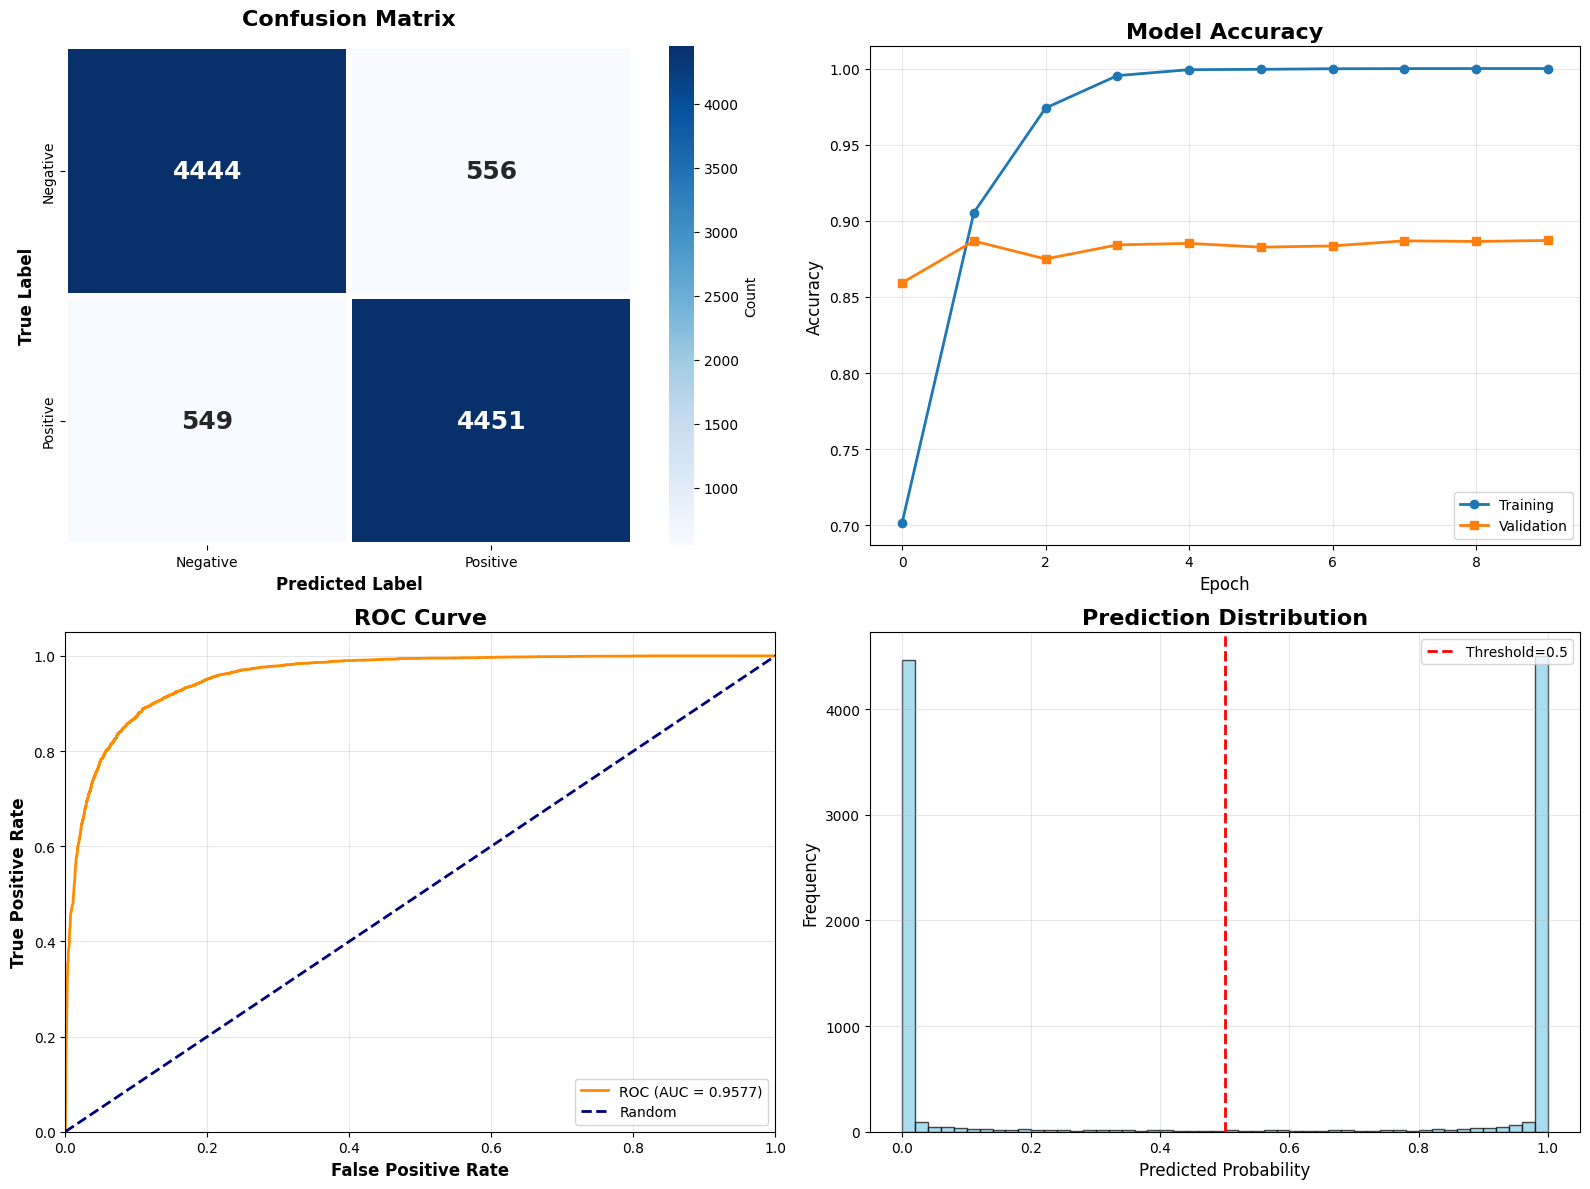

In [55]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            linewidths=3, linecolor='white',
            annot_kws={'size': 18, 'weight': 'bold'},
            cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
axes[0, 0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 2. Training History - Accuracy
axes[0, 1].plot(history_cnn.history['accuracy'], label='Training', linewidth=2, marker='o')
axes[0, 1].plot(history_cnn.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0, 1].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(loc='lower right', fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. ROC Curve
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('ROC Curve', fontsize=16, fontweight='bold')
axes[1, 0].legend(loc="lower right", fontsize=10)
axes[1, 0].grid(alpha=0.3)

# 4. Prediction Distribution
axes[1, 1].hist(y_pred_probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[1, 1].set_title('Prediction Distribution', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/cnn_model_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Evaluation plot saved: results/cnn_model_evaluation.png")
plt.show()

In [56]:
# ============================================================================
# SAVE CNN MODEL PACKAGE FOR DEPLOYMENT
# ============================================================================

print("="*70)
print("SAVING CNN MODEL PACKAGE")
print("="*70)

import pickle

# Create model package (similar to your original format)
cnn_model_package = {
    "model": cnn_model,  # Your trained CNN model
    "tokenizer": tokenizer,
    "max_tokens": max_tokens,
    "threshold": 0.5,
    "model_type": "cnn_keras",
    "embedding_size": 128,
    "vocab_size": 15000
}

# Save as .pkl file
with open('models/cnn_model_package.pkl', 'wb') as f:
    pickle.dump(cnn_model_package, f)

print("✓ Model package saved: models/cnn_model_package.pkl")

# Also save separately
cnn_model.save('models/cnn_model.keras')
print("✓ Model saved: models/cnn_model.keras")

with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved: models/tokenizer.pkl")

# Get file sizes
import os
pkg_size = os.path.getsize('models/cnn_model_package.pkl') / (1024 * 1024)
model_size = os.path.getsize('models/cnn_model.keras') / (1024 * 1024)

print(f"\nFile Sizes:")
print(f"  Package: {pkg_size:.2f} MB")
print(f"  Model: {model_size:.2f} MB")

SAVING CNN MODEL PACKAGE
✓ Model package saved: models/cnn_model_package.pkl
✓ Model saved: models/cnn_model.keras
✓ Tokenizer saved: models/tokenizer.pkl

File Sizes:
  Package: 31.14 MB
  Model: 24.27 MB
